In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# configs / defaults

In [2]:
!pip install ml_collections

In [3]:
import ml_collections
from flax import linen as nn


def get_config():
    config = ml_collections.ConfigDict()

    config.use_wandb = True

    # Weights & Biases
    config.wandb = wandb = ml_collections.ConfigDict()
    wandb.project = "burgers_fno"
    wandb.name = "best_model"
    wandb.tags = None
    wandb.group = None

    # Simulation Settings
    config.data = data = ml_collections.ConfigDict()
    data.in_channels = 2
    data.out_channels = 1
    data.spatial_dims = 2048

    # FNO Architecture
    config.arch = arch = ml_collections.ConfigDict()
    arch.modes = 24
    arch.width = 64
    arch.num_layers = 12
    arch.seed = 0
    arch.activation = nn.tanh
    arch.layer_init = nn.initializers.glorot_uniform()
    arch.lift_init = nn.initializers.glorot_uniform()
    arch.proj_init = nn.initializers.glorot_uniform()

    # Training
    config.training = training = ml_collections.ConfigDict()
    training.batch_size = 128
    training.epochs = 8000
    training.seed = 1

    # Optimizer
    config.optim = optim = ml_collections.ConfigDict()
    optim.optimizer = "adam"
    optim.learning_rate = 1e-3
    optim.b1 = 0.9
    optim.b2 = 0.999
    optim.eps = 1e-8
    optim.eps_root = 0.0

    optim.transition_steps = 250
    optim.transition_begin = 0
    optim.decay_rate = 0.9
    return config


# models

In [4]:
from typing import Callable, Dict, Tuple
from functools import partial

import jax.numpy as jnp
import ml_collections
import optax
import jax
from flax.training.train_state import TrainState
from flax import linen as nn
from jax import random, vmap, grad, jit


def _create_optimizer(
    config: ml_collections.ConfigDict,
) -> optax.GradientTransformation:
    lr = optax.exponential_decay(
        init_value=config.learning_rate,
        transition_steps=config.transition_steps,
        decay_rate=config.decay_rate,
    )

    optimizer = optax.adam(
        learning_rate=lr,
        b1=config.b1,
        b2=config.b2,
        eps=config.eps,
        eps_root=config.eps_root,
    )
    return optimizer


def _create_train_state(
    config: ml_collections.ConfigDict,
) -> TrainState:
    arch = config.arch
    data = config.data

    model = FNO1d(
        arch.width,
        data.out_channels,
        arch.modes,
        arch.activation,
        arch.num_layers,
        arch.lift_init,
        arch.proj_init,
        arch.layer_init,
    )

    dummy_input = jnp.ones((data.spatial_dims, data.in_channels))
    key = random.PRNGKey(arch.seed)
    params = model.init(key, dummy_input)

    tx = _create_optimizer(config.optim)

    state = TrainState.create(apply_fn=model.apply, params=params, tx=tx)
    return state


class FNO:
    def __init__(
        self,
        config: ml_collections.ConfigDict,
    ):
        self.config = config
        self.state = _create_train_state(config)

    def loss(
        self,
        params: Dict,
        state: TrainState,
        batch: Tuple[jnp.ndarray, jnp.ndarray],
    ) -> jnp.ndarray:
        data, labels = batch
        pred = vmap(lambda x: state.apply_fn(params, x))(data)
        loss = jnp.square(pred - labels)
        return loss.mean()

    @partial(jit, static_argnums=(0,))
    def step(
        self,
        state: TrainState,
        batch: Tuple[jnp.ndarray, jnp.ndarray],
    ) -> TrainState:
        grads = grad(self.loss)(state.params, state, batch)
        state = state.apply_gradients(grads=grads)
        return state


class SpectralConv1d(nn.Module):
    width: int
    modes: int

    def setup(
        self,
    ):
        scale = 1 / (self.width * self.width)
        self.weights = self.param(
            "global_kernel",
            lambda rng, shape: random.uniform(
                rng, shape, minval=-scale, maxval=scale
            ),
            (2, self.modes, self.width, self.width),
        )

    @nn.compact
    def __call__(
        self,
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        spatial_resolution = x.shape[0]

        x_ft = jnp.fft.rfft(x, axis=0)
        x_ft_trunc = x_ft[: self.modes, :]

        R = jax.lax.complex(self.weights[0, ...], self.weights[1, ...])

        R_x_ft = jnp.einsum("Mio,Mi->Mo", R, x_ft_trunc)

        result = jnp.zeros((x_ft.shape[0], self.width), dtype=x_ft.dtype)
        result = result.at[: self.modes, :].set(R_x_ft)

        inv_ft_R_x_ft = jnp.fft.irfft(result, n=spatial_resolution, axis=0)
        return inv_ft_R_x_ft


class FNOBlock1d(nn.Module):
    width: int
    modes: int
    activation: Callable
    layer_init: Callable

    @nn.compact
    def __call__(
        self,
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        spectral_conv = SpectralConv1d(self.width, self.modes)(x)
        local_conv = nn.Conv(
            self.width,
            kernel_size=(1,),
            kernel_init=self.layer_init,
            name="local",
        )(x)
        return self.activation(spectral_conv + local_conv)


class FNO1d(nn.Module):
    width: int
    out_channels: int
    modes: int
    activation: Callable
    num_layers: int
    lift_init: Callable
    proj_init: Callable
    layer_init: Callable

    @nn.compact
    def __call__(
        self,
        x: jnp.ndarray,
    ) -> jnp.ndarray:
        x = nn.Conv(
            self.width,
            kernel_size=(1,),
            kernel_init=self.lift_init,
            name="lifting",
        )(x)
        for _ in range(self.num_layers):
            x = FNOBlock1d(
                self.width, self.modes, self.activation, self.layer_init
            )(x)
        x = nn.Conv(
            self.out_channels,
            kernel_size=(1,),
            kernel_init=self.proj_init,
            name="projection",
        )(x)
        return x


# results

True


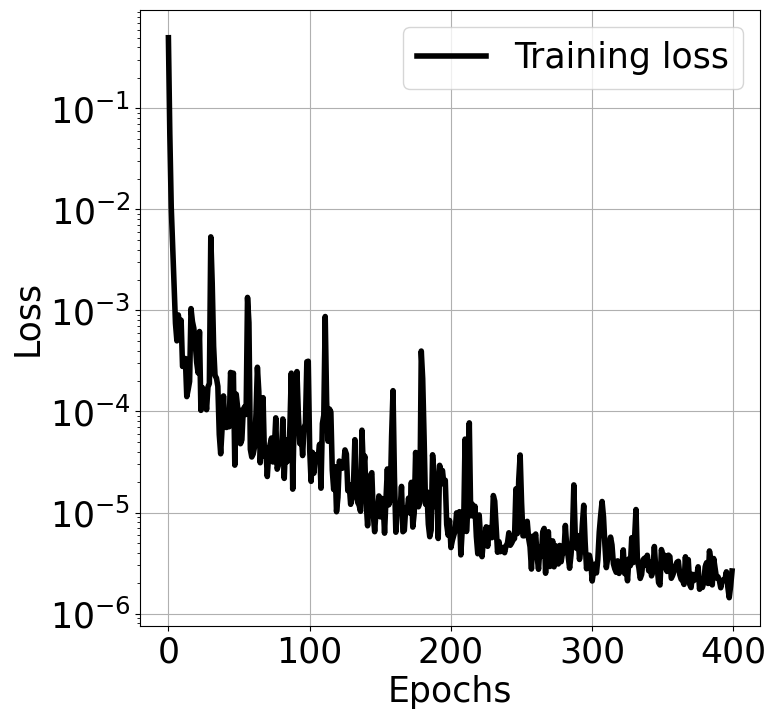

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb:   1 of 1 files downloaded.  


0.0017538986
98.24219


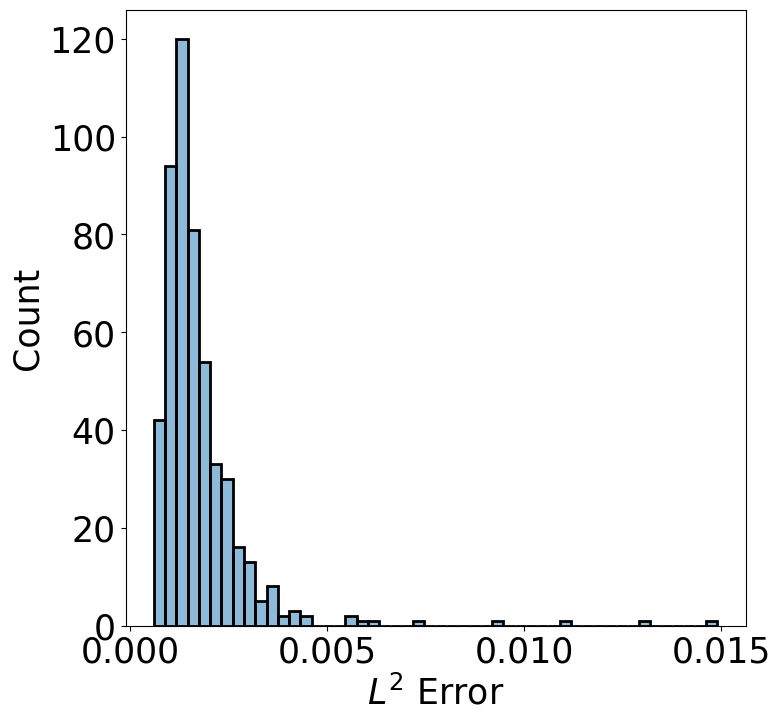

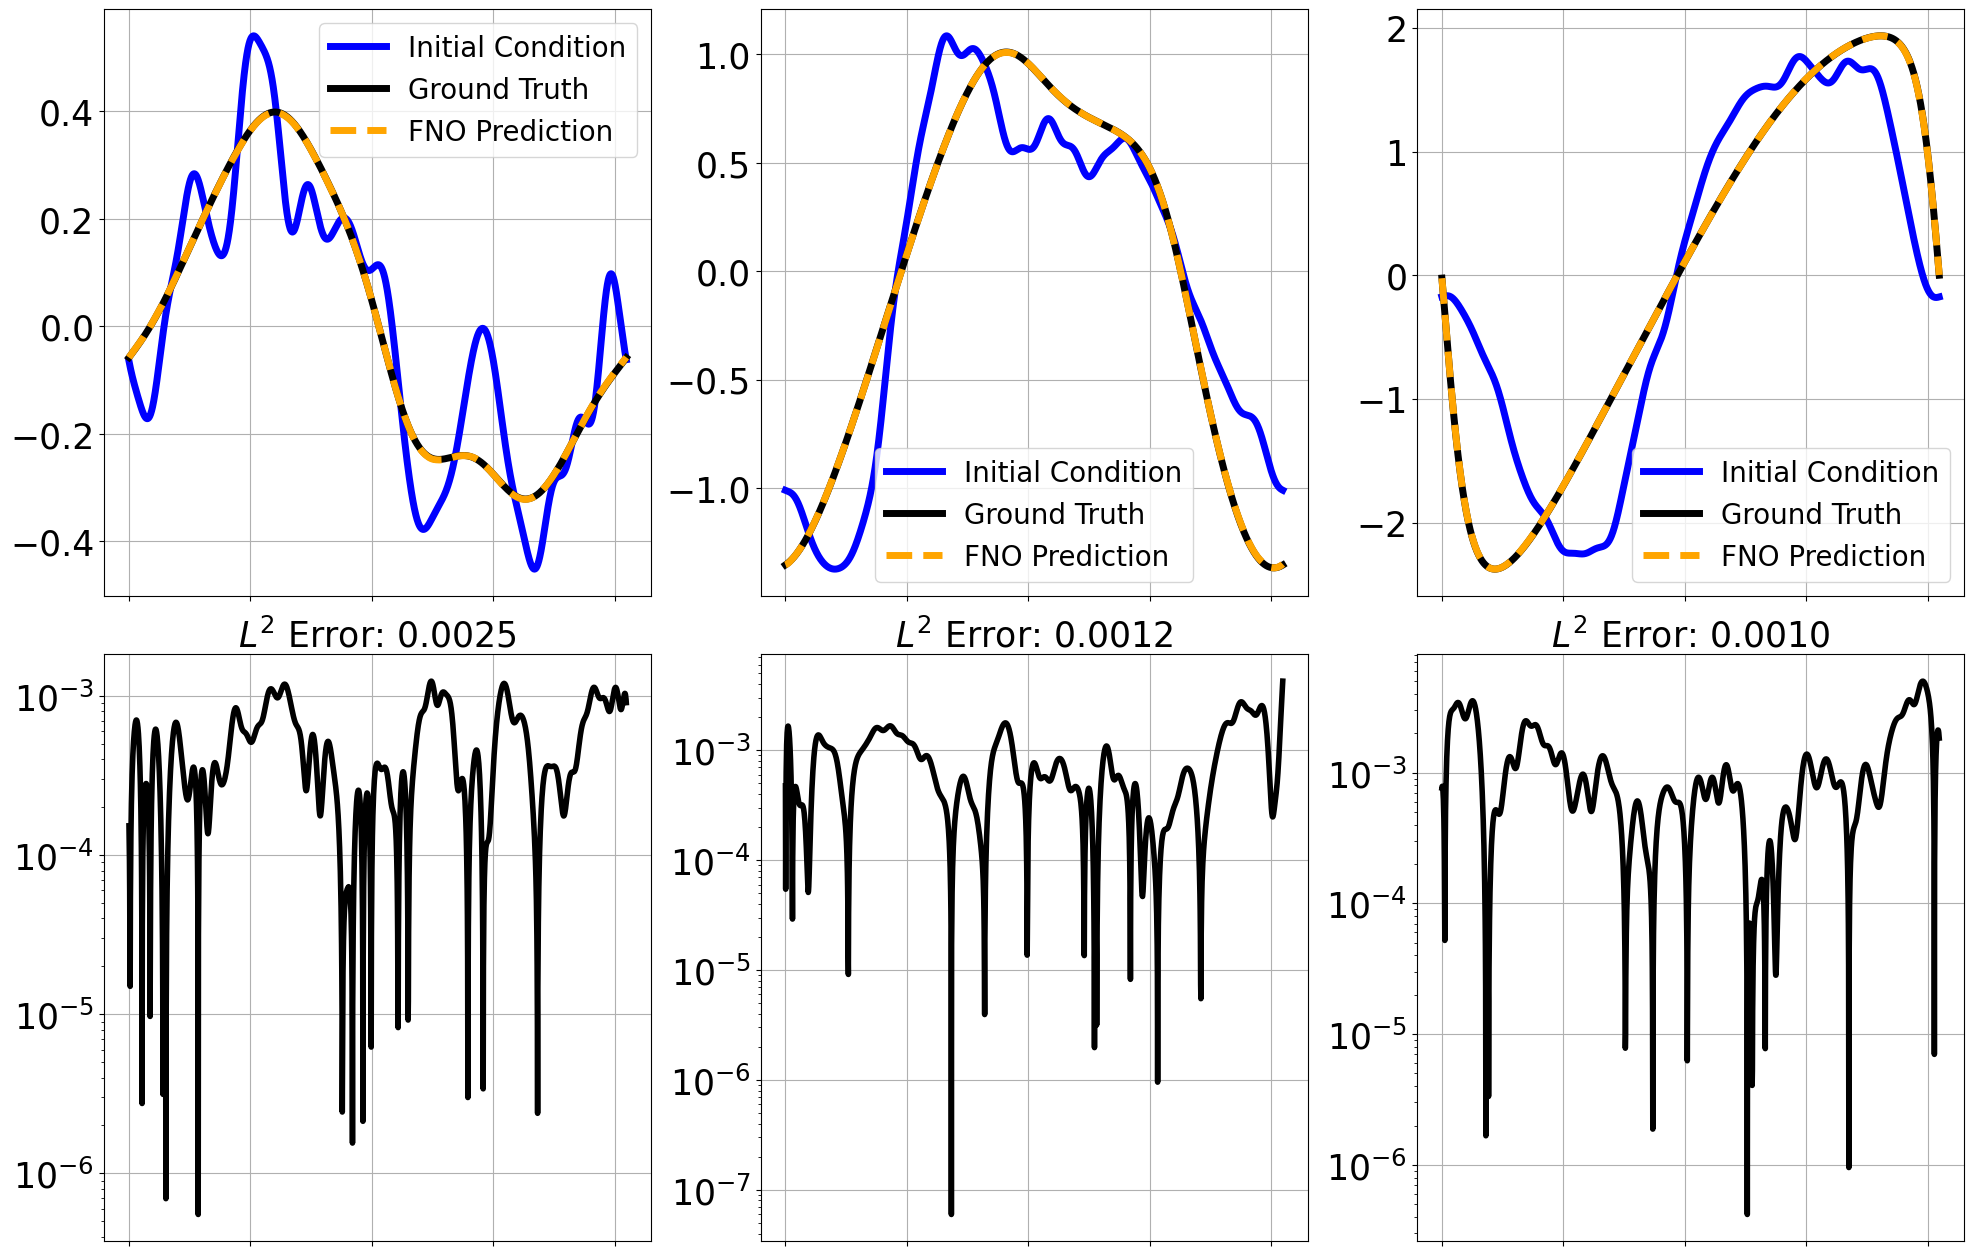

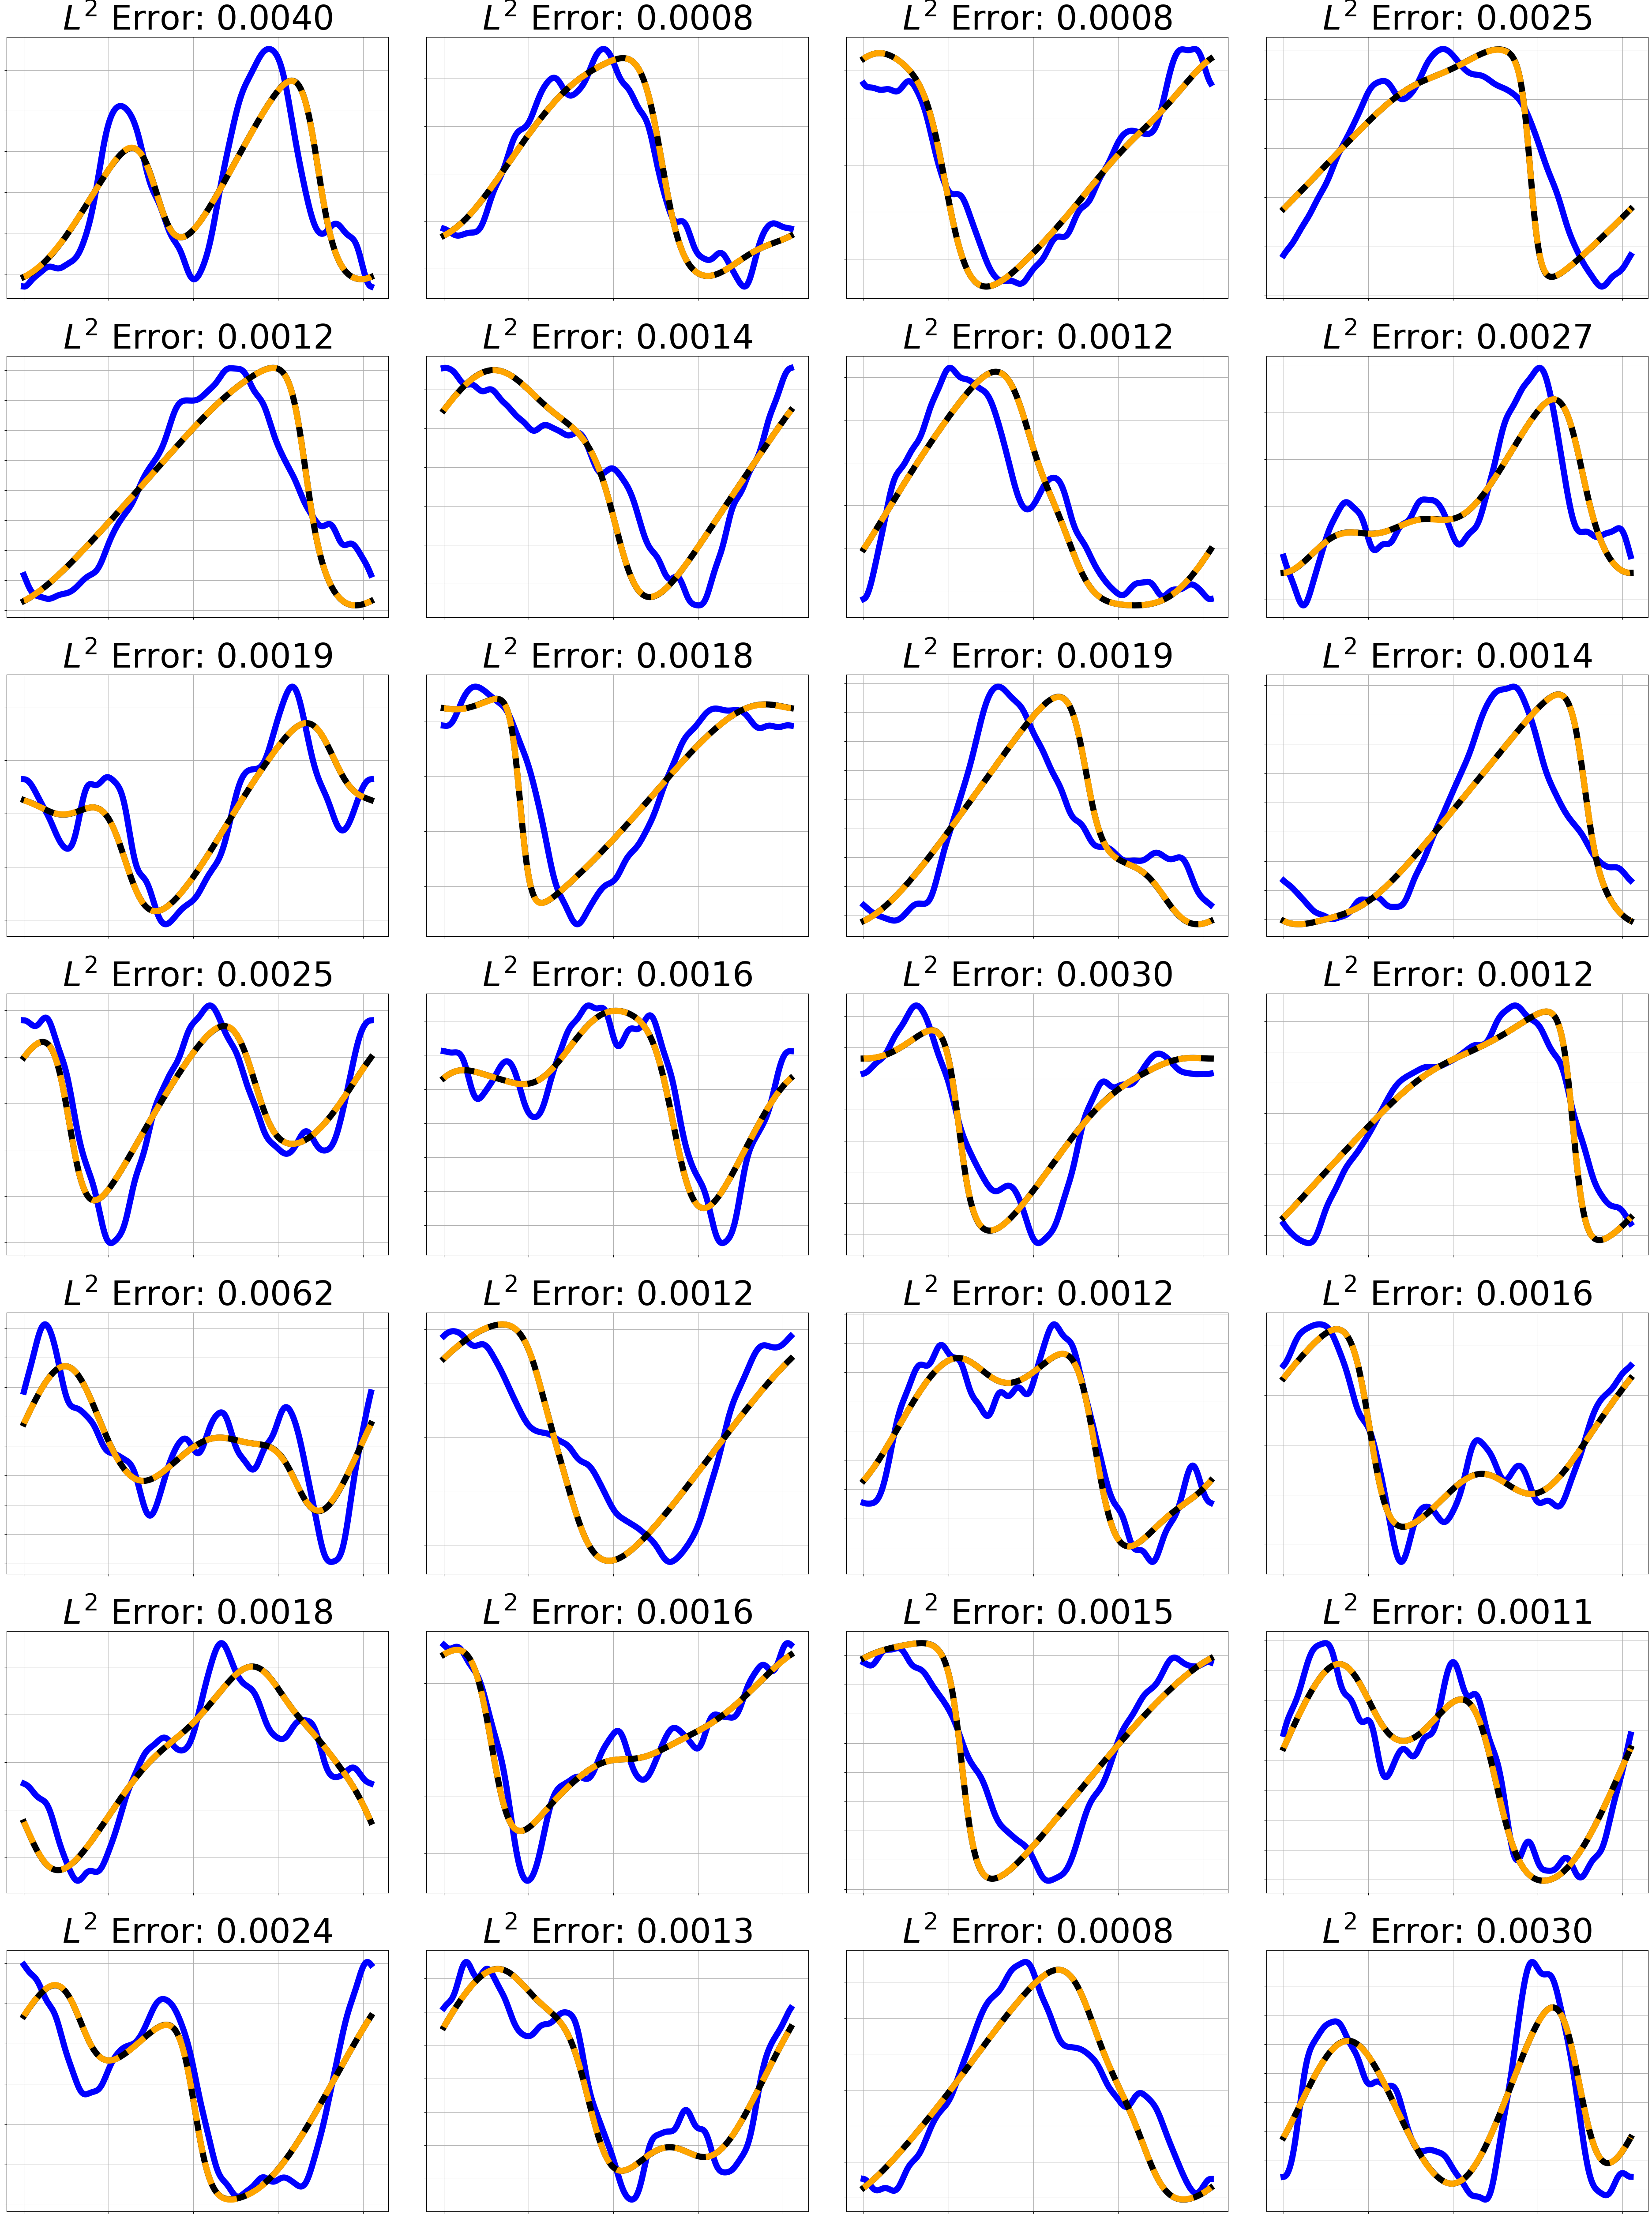

In [5]:
import pickle
import os

import matplotlib.pyplot as plt
import jax.numpy as jnp
import seaborn as sns
import numpy as npy
import wandb
from jax import random

wandb_username = "skoohy-penn"

api = wandb.Api()
runs = list(api.runs("burgers"))
run = runs[0]
run_name = run.name
config = run.config
history = run.history(keys=["train_loss"])
loss = history["train_loss"].tolist()

dpi = 100

fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
ax.plot(loss, label="Training loss", c="k", lw=4)
ax.tick_params(axis="both", labelsize=25)
ax.set_yscale("log")
ax.set_ylabel("Loss", fontsize=25)
ax.set_xlabel("Epochs", fontsize=25)
ax.legend(fontsize=25)
ax.grid()
plt.show()

data = npy.load(
    "/content/drive/My Drive/data/burgers_data.npy", allow_pickle=True
).item()

a_with_mesh = data["a_with_mesh"]
u = data["u"]

train_split = int(0.75 * a_with_mesh.shape[0])

train_x = a_with_mesh[:train_split, ::4, :]
train_x_mean = train_x.mean((0, 1))
train_x_std = train_x.std((0, 1))
train_x = (train_x - train_x_mean) / train_x_std

train_y = u[:train_split, ::4, :]
train_y_mean = train_y.mean((0, 1))
train_y_std = train_y.std((0, 1))
train_y = (train_y - train_y_mean) / train_y_std

test_x = (a_with_mesh[train_split:, ::4, :] - train_x_mean) / train_x_std
test_y = (u[train_split:, ::4, :] - train_y_mean) / train_y_std

artifact = api.artifact(
    f"{wandb_username}/burgers/{run.name}_model_params:latest",
    type="model",
)

artifact_dir = artifact.download()

file_path = os.path.join(artifact_dir, f"{run_name}_model_params.pkl")

with open(file_path, "rb") as f:
    loaded_params = pickle.load(f)

full_config = get_config()
model = FNO(full_config)
model.state = model.state.replace(params=loaded_params)

predictions = vmap(lambda x: model.state.apply_fn(model.state.params, x))(
    test_x
)
l2_errors = jnp.linalg.norm(predictions - test_y, axis=1) / jnp.linalg.norm(
    test_y, axis=1
)

print(l2_errors.mean())
print(((l2_errors < 0.005).sum() / l2_errors.shape[0]) * 100)

fig, ax = plt.subplots(figsize=(8, 8), dpi=dpi)
sns.histplot(l2_errors, legend=False, linewidth=2, bins=50)
ax.tick_params(axis="both", labelsize=25)
ax.set_ylabel("Count", fontsize=25)
ax.set_xlabel("$L^2$ Error", fontsize=25)
plt.show()

cols = 2
rows = 3

key, subkey = random.split(random.PRNGKey(1234))
rand_ex = random.randint(subkey, (rows,), 0, len(test_x))

fig, ax = plt.subplots(cols, rows, figsize=(24, 16), dpi=dpi)
for i, (x_test, y_test) in enumerate(zip(test_x[rand_ex], test_y[rand_ex])):
    model_test = model.state.apply_fn(model.state.params, x_test).flatten()

    ax[0, i].plot(x_test[:, 0], label="Initial Condition", c="b", lw=5)
    ax[0, i].plot(y_test, label="Ground Truth", c="k", lw=5)
    ax[0, i].plot(model_test, "--", label="FNO Prediction", c="orange", lw=5)
    ax[0, i].legend(fontsize=20)
    ax[0, i].grid(True)
    ax[0, i].set_xticklabels([])
    ax[0, i].tick_params(axis="y", labelsize=25)

    error = abs(model_test - y_test.flatten())
    ax[1, i].plot(error, c="k", lw=4)
    ax[1, i].set_yscale("log")
    ax[1, i].set_title(
        "$L^2$ Error: {:.4f}".format(
            jnp.linalg.norm(error) / jnp.linalg.norm(y_test)
        ),
        fontsize=25,
    )
    ax[1, i].grid(True)
    ax[1, i].set_xticklabels([])
    ax[1, i].tick_params(axis="y", labelsize=25)

fig.subplots_adjust(hspace=0.1)
plt.show()

num_ex = 28

idx_all = range(len(test_x))
choices = jnp.array([idx for idx in idx_all if idx not in rand_ex])
rand_ex2 = random.choice(
    random.PRNGKey(246810), choices, shape=(num_ex,), replace=False
)

fig, ax = plt.subplots(num_ex // 4, 4, figsize=(6 * 8, 8 * 8), dpi=dpi)

ax = ax.flatten()
for i, (x_test, y_test) in enumerate(zip(test_x[rand_ex2], test_y[rand_ex2])):
    model_test = model.state.apply_fn(model.state.params, x_test).flatten()

    ax[i].plot(x_test[:, 0], label="Initial Condition", c="b", lw=10)
    ax[i].plot(y_test, label="Ground Truth", c="k", lw=10)
    ax[i].plot(model_test, "--", label="FNO Prediction", c="orange", lw=10)
    ax[i].grid(True)
    ax[i].set_xticklabels([])
    ax[i].set_yticklabels([])
    error = abs(model_test - y_test.flatten())
    ax[i].set_title(
        "$L^2$ Error: {:.4f}".format(
            jnp.linalg.norm(error) / jnp.linalg.norm(y_test)
        ),
        fontsize=55,
    )

fig.subplots_adjust(hspace=0.22, wspace=0.1)
plt.show()
